# 逐次更新型の予測モデル(SARIMA)

In [1]:
import pandas as pd

# 全データを読み込む
data = pd.read_csv('international-airline-passengers.csv')

data = data.iloc[:,1]

print(len(data))
data.head()

144


0    112
1    118
2    132
3    129
4    121
Name: IAP, dtype: int64

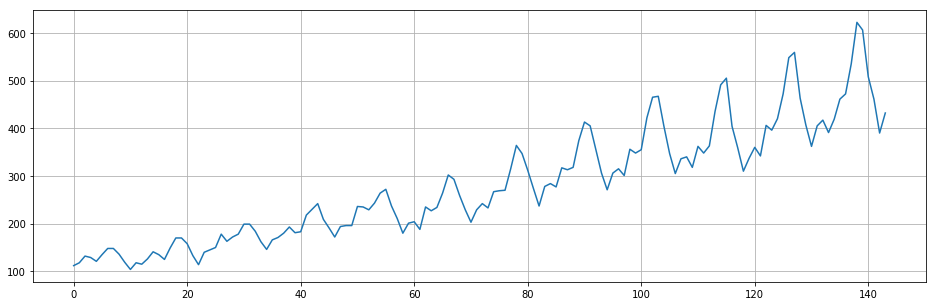

In [3]:
import matplotlib.pyplot as plt
# pandasのデータをplotする際にWarning避けのためにimport
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# jupyter notebook上で図を表示するために挿入
%matplotlib inline

# 値のtypeをintからfloatに変更する．
data = data.astype(float)

# 図示する
plt.figure(figsize=(16,5))
plt.grid()

plt.plot(data)
plt.show();

# 予測値と実測値の誤差を計測してモデルを更新する

In [18]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# 総当たり法を実施して一番良いモデルを返す関数
def model_selection(data):
    max_p = 3
    max_d = 1
    max_q = 3
    max_sp = 1
    max_sd = 1
    max_sq = 1

    pattern = max_p*(max_d + 1)*(max_q + 1)*(max_sp + 1)*(max_sd + 1)*(max_sq + 1)

    model_list = pd.DataFrame(index=range(pattern), columns=["order", "season", "aic"])

    num = 0
    for p in range(1, max_p + 1):
        for d in range(0, max_d + 1):
            for q in range(0, max_q + 1):
                for sp in range(0, max_sp + 1):
                    for sd in range(0, max_sd + 1):
                        for sq in range(0, max_sq + 1):
                            model = sm.tsa.SARIMAX(data, 
                                                   order = (p,d,q), 
                                                   seasonal_order = (sp,sd,sq,12), 
                                                   simple_differencing = True,
                                                   enforce_stationarity = False, 
                                                   enforce_invertibility = False).fit()
                            model_list.iloc[num]["order"] = (p, d, q)
                            model_list.iloc[num]["season"] = (sp, sd, sq, 12)
                            model_list.iloc[num]["aic"] = model.aic
                            num += 1
    
    order_ = model_list[model_list.aic == min(model_list.aic)].iloc[0][0]
    season = model_list[model_list.aic == min(model_list.aic)].iloc[0][1]
    
    bestmodel = sm.tsa.SARIMAX(data, 
                               order = order_, 
                               seasonal_order = season, 
                               enforce_stationarity = False, 
                               enforce_invertibility = False).fit()
    
    return bestmodel


def transform_frame(pred_list):
    true_list = []
    for i in range(len(pred_list[0])):
        true_list.append(pred_list[0][i])
        
    for j in range(1, len(pred_list)):
        true_list.append(pred_list[j])
        
    return true_list


def online(data, train_size):
    bestmodel = model_selection(data[:train_size])
    pred = bestmodel.predict(0, len(data))
    ad_count = 0
    pred_list = [pred[:train_size+1]]
    for i in range(train_size+1, len(data)):
        if i < len(data) - 2:
            # 訓練データに用いたデータの標準偏差×3以上の乖離があった場合はモデルを再構築
            if np.abs(data[i] - pred[i]) > 3.0 * np.std(data[:i]):
                bestmodel = model_selection(data[:i])
                pred = bestmodel.predict(0, len(data))
                pred_list.append(pred[i+1])
                ad_count += 1
            else:
                pred = bestmodel.predict(0, len(data))
                pred_list.append(pred[i])
        else:
            pred = bestmodel.predict(0, len(data))
            pred_list.append(pred[i])
    
    pred_list = transform_frame(pred_list)
    
    return pred_list, ad_count


In [12]:
pred_list, ad = online(data, 80)

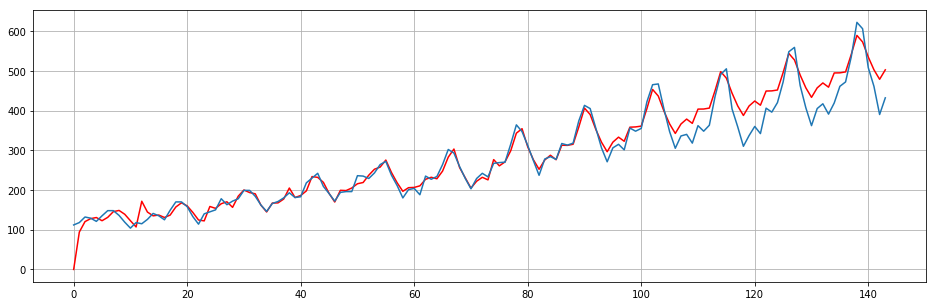

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.grid()

plt.plot(pred_list, 'r')
plt.plot(data);

# 毎回更新するタイプ
訓練データのサイズを毎度更新して予測をするため、毎回総当たり法を実施することになる．つまり時間がかかる．

In [17]:
def normal_make(data, num):
    data_list = []
    for i in range(num):
        data_list.append(data.iloc[:,i])
        
    return data_list


def zero_eliminate(data, num):
    data_list = []
    for i in range(num):
        data_ = data.iloc[:,i]
        for j in range(len(data)):
            if data_[0] == 0:
                data_ = data_[j+1:]
            else:
                break
        data_list.append(data_)
        
    return data_list


def al_update(data, train_size):
    bestmodel = model_selection(data[:train_size])
    pred = bestmodel.predict(0, len(data))
    pred_list = [pred[:train_size+1]]
    for i in range(train_size+1, len(data)):
        if i < len(data) - 2:
            bestmodel = model_selection(data[:i])
            pred = bestmodel.predict(0, len(data))
            pred_list.append(pred[i+1])
        else:
            pred = bestmodel.predict(0, len(data))
            pred_list.append(pred[i])

    pred_list = transform_frame(pred_list)
    
    return pred_list

In [19]:
import time

start = time.time()
subpred = al_update(data, 80)
end = time.time()
print("Complete Time series!", end - start)

Complete Time series! 2473.585993528366


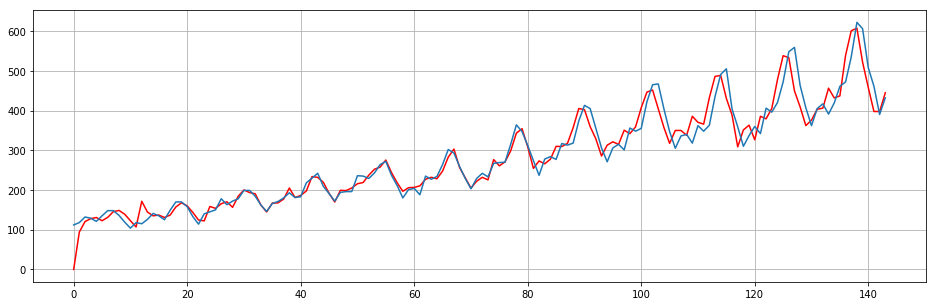

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.grid()

plt.plot(subpred, 'r')
plt.plot(data);